In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, GradientBoostingRegressor
import numpy as np
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import matplotlib.pyplot as plt

In [4]:
%cd /content/drive/MyDrive/вышка/диплом

/content/drive/MyDrive/вышка/диплом


In [5]:
dataset = pd.read_csv('dataset_plusextra_nlp_features_target_classes_no_naive.csv',sep='\t')
target = 'verb'
intelligence = target #+ '_classes'
SEED = 42

dataset = dataset[dataset['N_words'] > 2]
df = dataset[[intelligence,
                    'mean_sent_depth',	'max_synt_depth',	'min_synt_depth',
                    'N_acl:relcl',	'N_acl',	'N_advcl',	'N_relative',
                    'mean_freq_ipm',	'mean_freq_d',	'min_freq_ipm',	'min_freq_d',	
                    'N_words',	'mean_Nwords_sent', 'max_Nwords_sent',	'mean_len_words',
                    'max_len_words',	'N_repeated_words',	'N_most_repeated_word',
                    'N_pronn_pers_first', 'N_pronn_pers_sec_third', 'N_adj',
                    'N_adj_degree_compar', 'N_adj_degree_super', 'N_verb_mood_ind',
                    'N_verb_mood_imp', 'N_verb_aspect_imp', 'N_verb_aspect_perf',
                    'N_verb_voice_act', 'N_verb_voice_pass', 'N_verb_voice_mid',
                    'N_verb_tense_past', 'N_verb_tense_pres', 'N_verb_tense_fut'      
                    ]]

train_data, extra_data = train_test_split(df, test_size=0.2,
                                        random_state=SEED)


In [7]:
target_values = ['mean_sent_depth',	'max_synt_depth',	'min_synt_depth',
                    'N_acl:relcl',	'N_acl',	'N_advcl',	'N_relative',
                    'mean_freq_ipm',	'mean_freq_d',	'min_freq_ipm',	'min_freq_d',	
                    'N_words',	'mean_Nwords_sent', 'max_Nwords_sent',	'mean_len_words',
                    'max_len_words',	'N_repeated_words',	'N_most_repeated_word',
                    'N_pronn_pers_first', 'N_pronn_pers_sec_third', 'N_adj',
                    'N_adj_degree_compar', 'N_adj_degree_super', 'N_verb_mood_ind',
                    'N_verb_mood_imp', 'N_verb_aspect_imp', 'N_verb_aspect_perf',
                    'N_verb_voice_act', 'N_verb_voice_pass', 'N_verb_voice_mid',
                    'N_verb_tense_past', 'N_verb_tense_pres', 'N_verb_tense_fut'      
                    ]

def get_x_y(subset):

  y_set = subset[[intelligence]]
  x_set = subset[target_values]
  return x_set, y_set

X_train, y_train = get_x_y(train_data)
X_test, Y_test = get_x_y(extra_data)

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.metrics import classification_report
sc = MinMaxScaler()
x_train = sc.fit_transform(X_train)
# x_valid = sc.transform(X_val)
x_test = sc.transform(X_test)

x_train_df = pd.DataFrame(x_train, columns=target_values) 
x_test_df = pd.DataFrame(x_test, columns=target_values) 

In [7]:
!pip install --quiet shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.7 MB/s eta 0:00:00


## Regressor

In [9]:
import xgboost
import shap

params = {
    "objective": "reg:squarederror",
    "n_estimators":1000,
    "max_depth": 10,
    "subsample": 0.5,
    "colsample_bytree": 0.9,
    "colsample_bylevel": 0.8,
    "reg_alpha": 0.002,
    'scale_pos_weight':1,
    'validate_parameters':10,
    "random_state": 42,
}

model = xgboost.XGBRFRegressor(**params).fit(x_train_df, y_train)

In [10]:
MSE_train = mean_squared_error(y_train, model.predict(x_train_df))
MSE_test = mean_squared_error(Y_test, model.predict(x_test_df))
print(f'RMSE for train: {math.sqrt(MSE_train)}')
print(f'RMSE for test: {math.sqrt(MSE_test)}')

RMSE for train: 9.292739885328048
RMSE for test: 11.212259081778377


In [11]:
r2_score(y_train, model.predict(x_train_df))

0.4245790204621118

In [12]:
r2_score(Y_test, model.predict(x_test_df))

0.14871338345853646

In [ ]:
!pip install pdpbox

## Shap intepreter

In [74]:
explainer = shap.Explainer(model)
shap_values = explainer(x_test_df)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


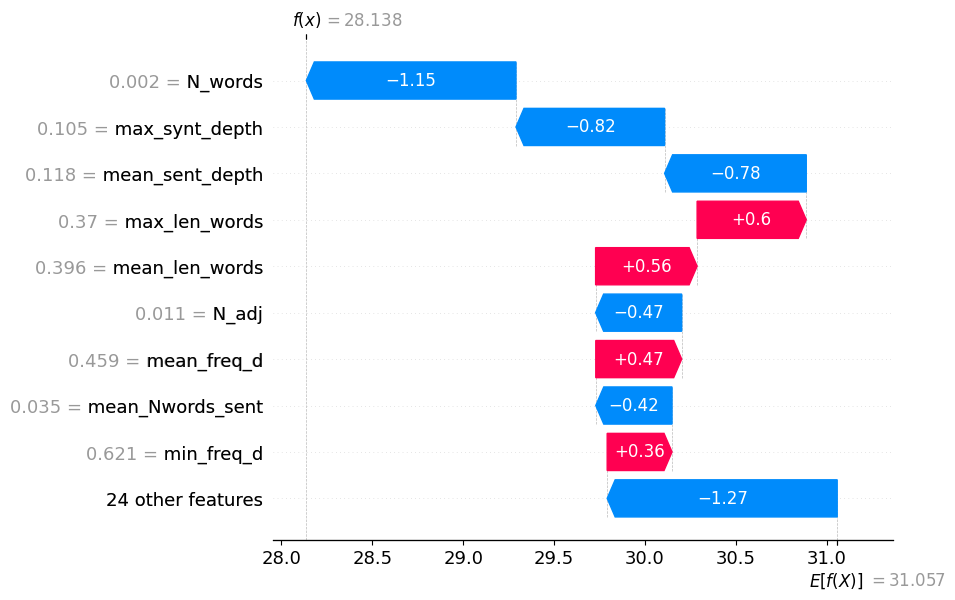

In [75]:
shap.plots.waterfall(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


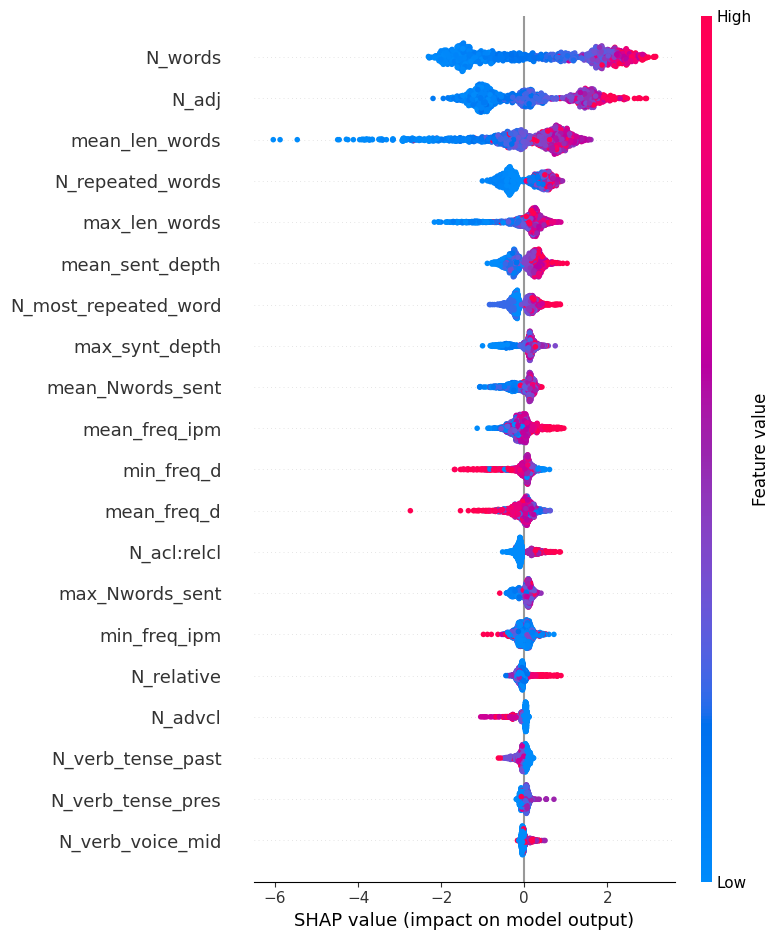

In [76]:
shap.summary_plot(shap_values, x_test_df)

In [77]:
import matplotlib.pyplot as plt

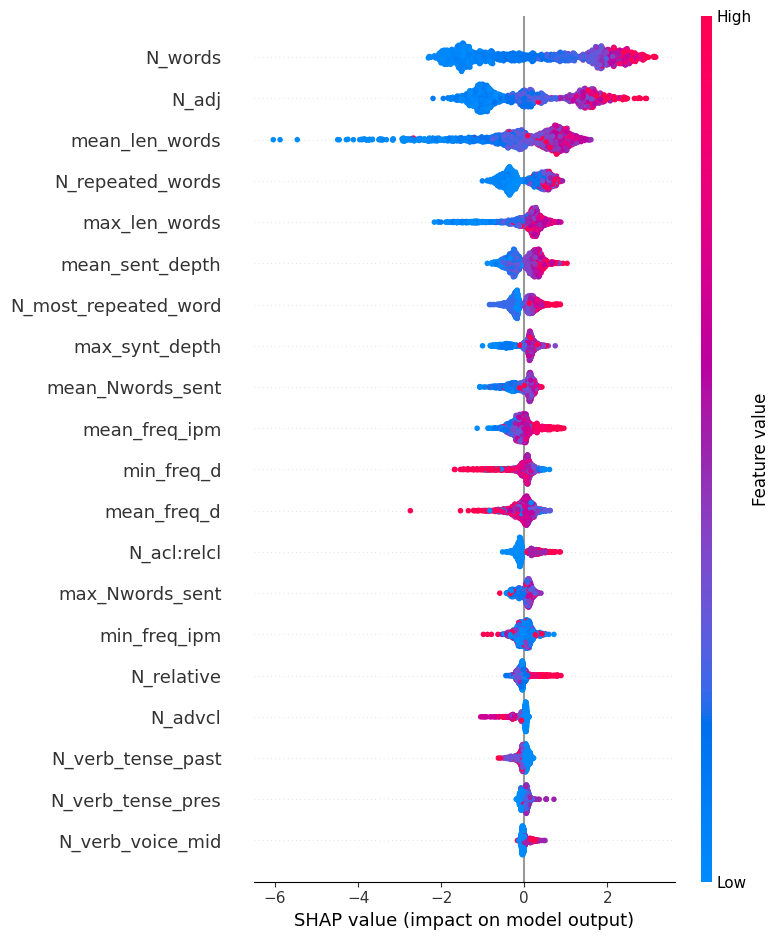

In [78]:
shap.summary_plot(shap_values, x_test_df, show=False)
plt.savefig("features/plots/verb.png")
plt.show()

## Pdp explainers

In [14]:
from pdpbox import pdp, get_dataset, info_plots

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5181 entries, 3048 to 865
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   verb                    5181 non-null   int64  
 1   mean_sent_depth         5181 non-null   float64
 2   max_synt_depth          5181 non-null   int64  
 3   min_synt_depth          5181 non-null   int64  
 4   N_acl:relcl             5181 non-null   int64  
 5   N_acl                   5181 non-null   int64  
 6   N_advcl                 5181 non-null   int64  
 7   N_relative              5181 non-null   int64  
 8   mean_freq_ipm           5181 non-null   float64
 9   mean_freq_d             5181 non-null   float64
 10  min_freq_ipm            5181 non-null   float64
 11  min_freq_d              5181 non-null   float64
 12  N_words                 5181 non-null   int64  
 13  mean_Nwords_sent        5181 non-null   float64
 14  max_Nwords_sent         5181 non-null 

In [26]:
x_test_df['predicted_verb'] = model.predict(x_test_df)

In [27]:
def get_pdp_plot_figs(feature, target_param):

  fig, axes, summary_df = info_plots.target_plot(
      df=x_test_df, 
      feature=feature, feature_name=feature, target=f'predicted_{target_param}'
  )

  plt.savefig(f'features/plots/{target_param}_pdp/pdpplot_{target_param}_{feature}.png')

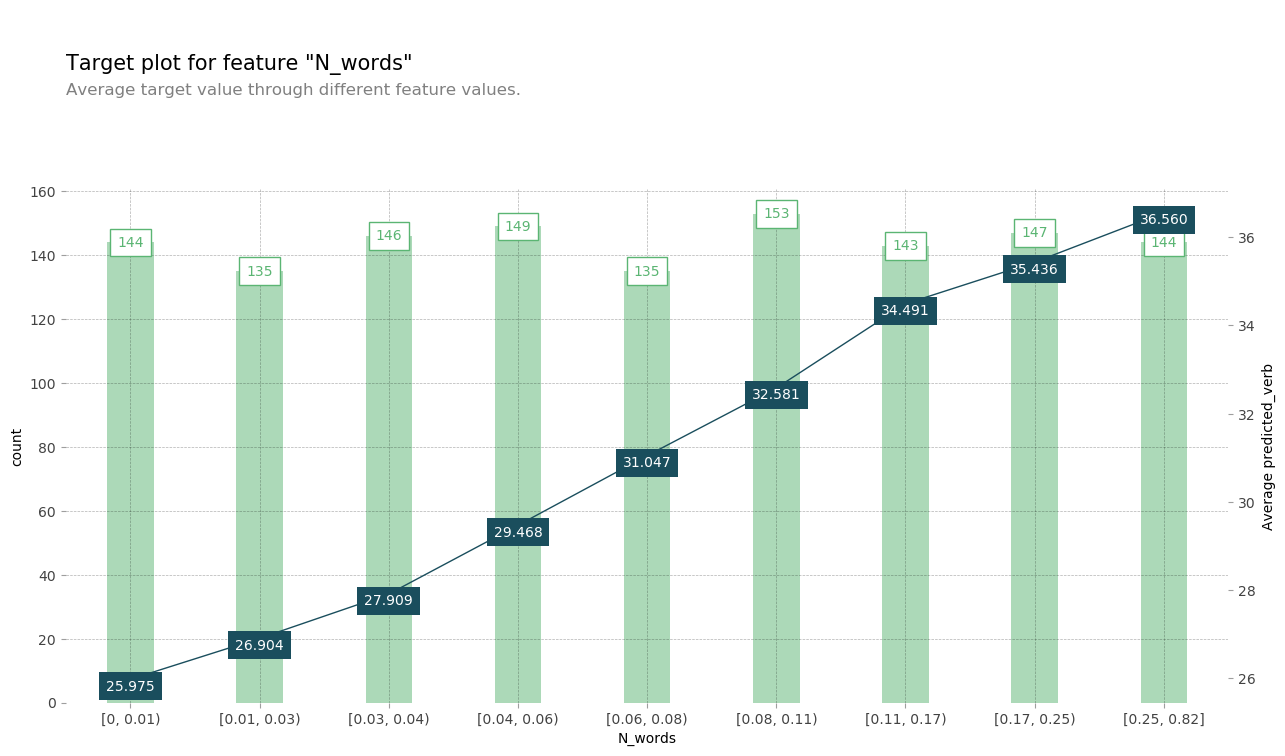

In [28]:
get_pdp_plot_figs('N_words', 'verb')

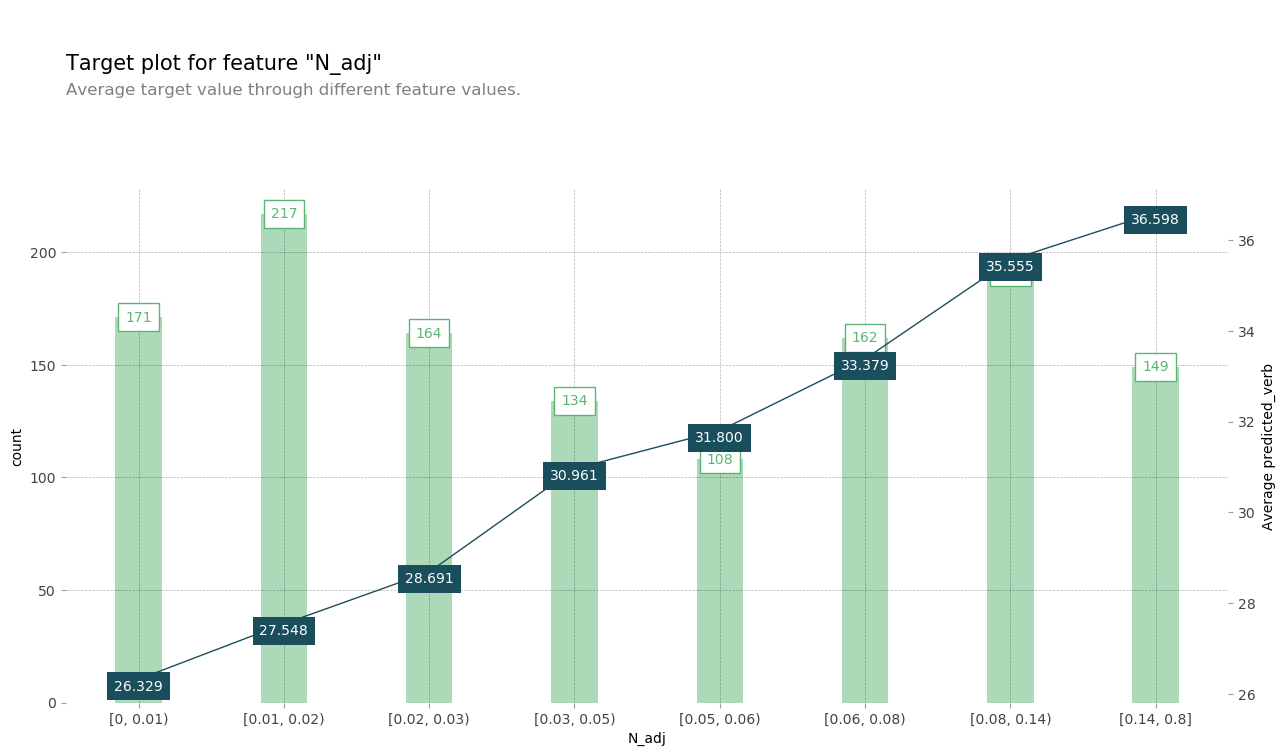

In [29]:
get_pdp_plot_figs('N_adj', 'verb')

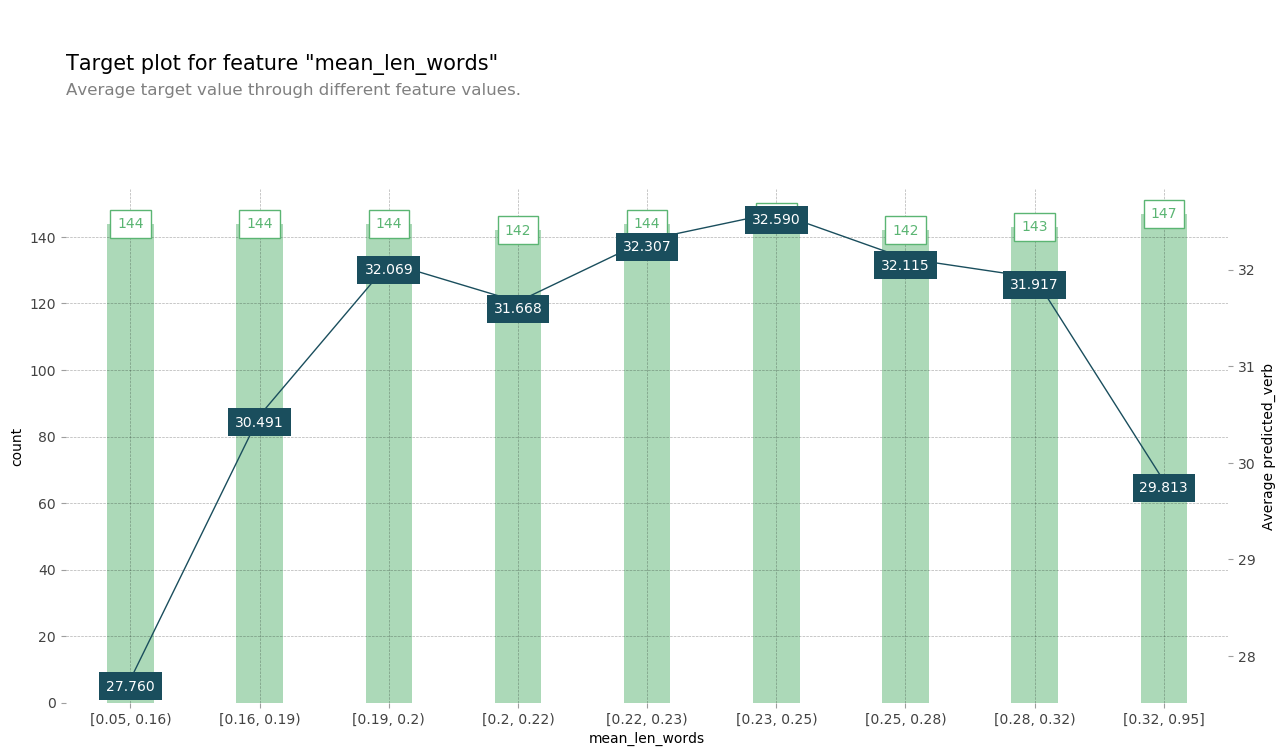

In [30]:
get_pdp_plot_figs('mean_len_words', 'verb')

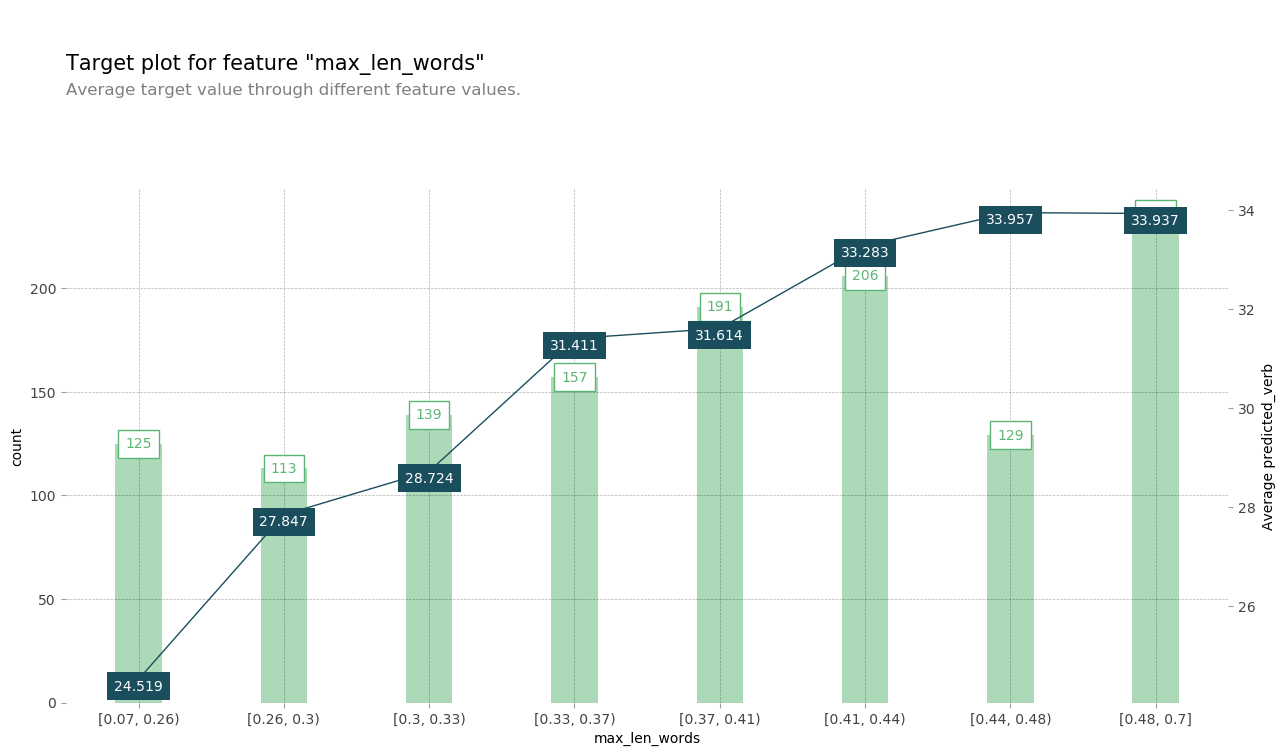

In [31]:
get_pdp_plot_figs('max_len_words', 'verb')

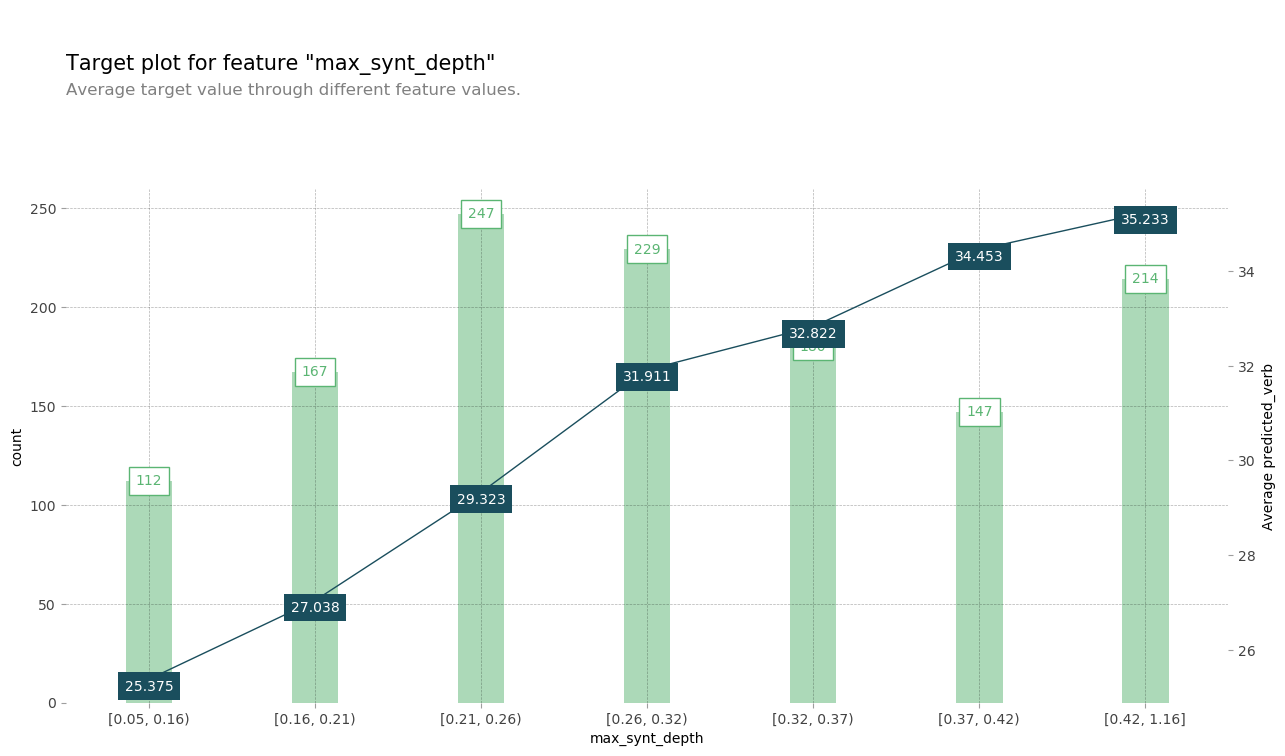

In [32]:
get_pdp_plot_figs('max_synt_depth', 'verb')

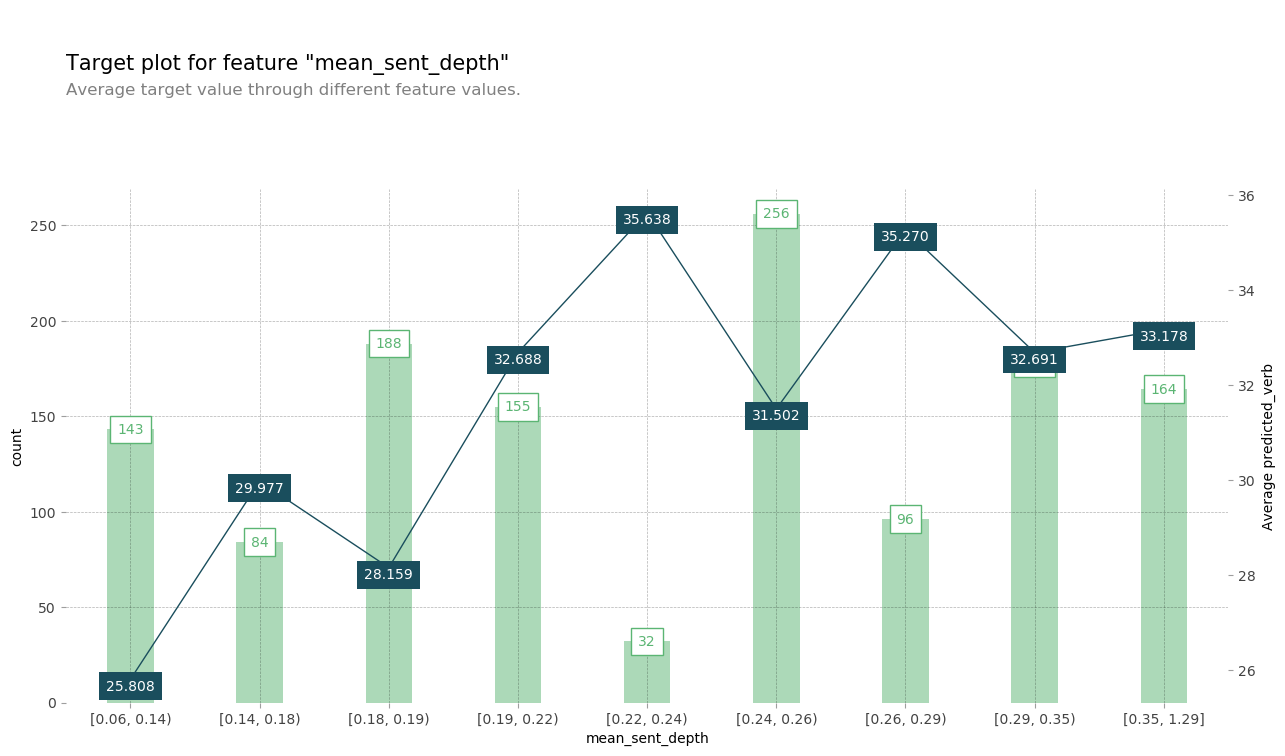

In [33]:
get_pdp_plot_figs('mean_sent_depth', 'verb')

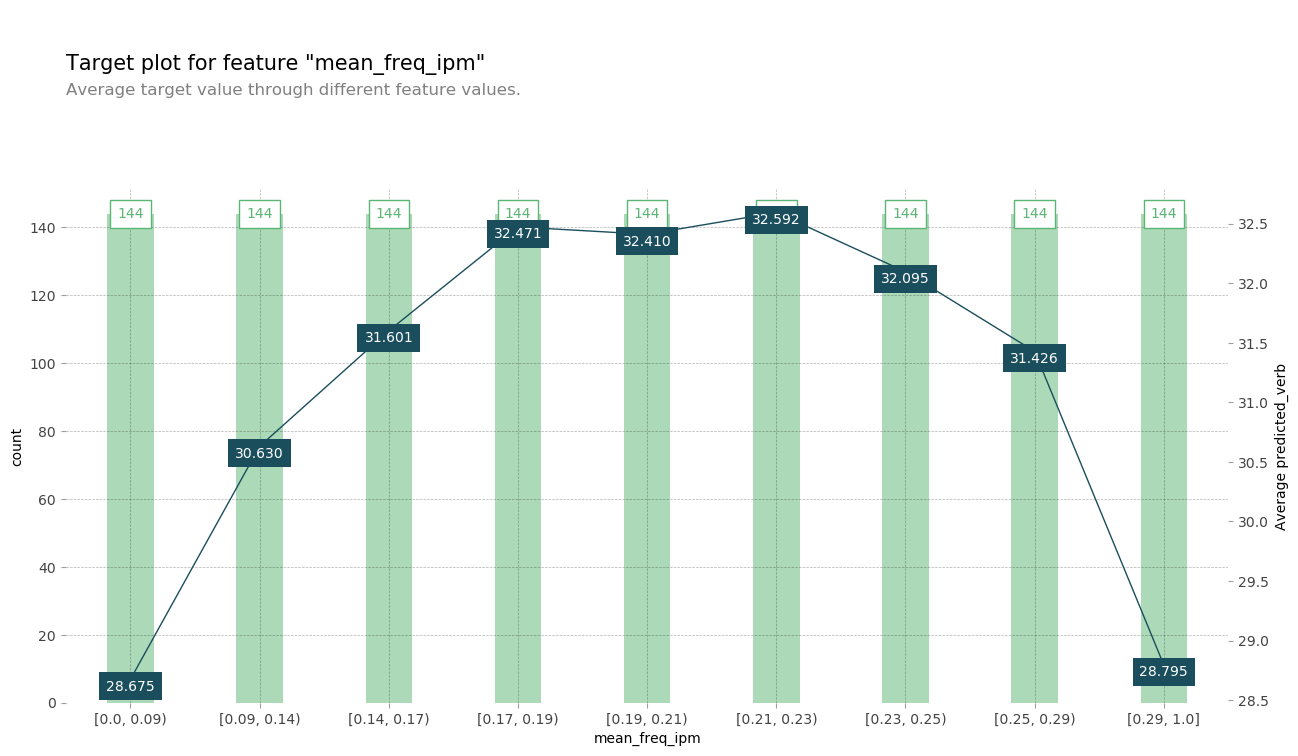

In [34]:
get_pdp_plot_figs('mean_freq_ipm', 'verb')

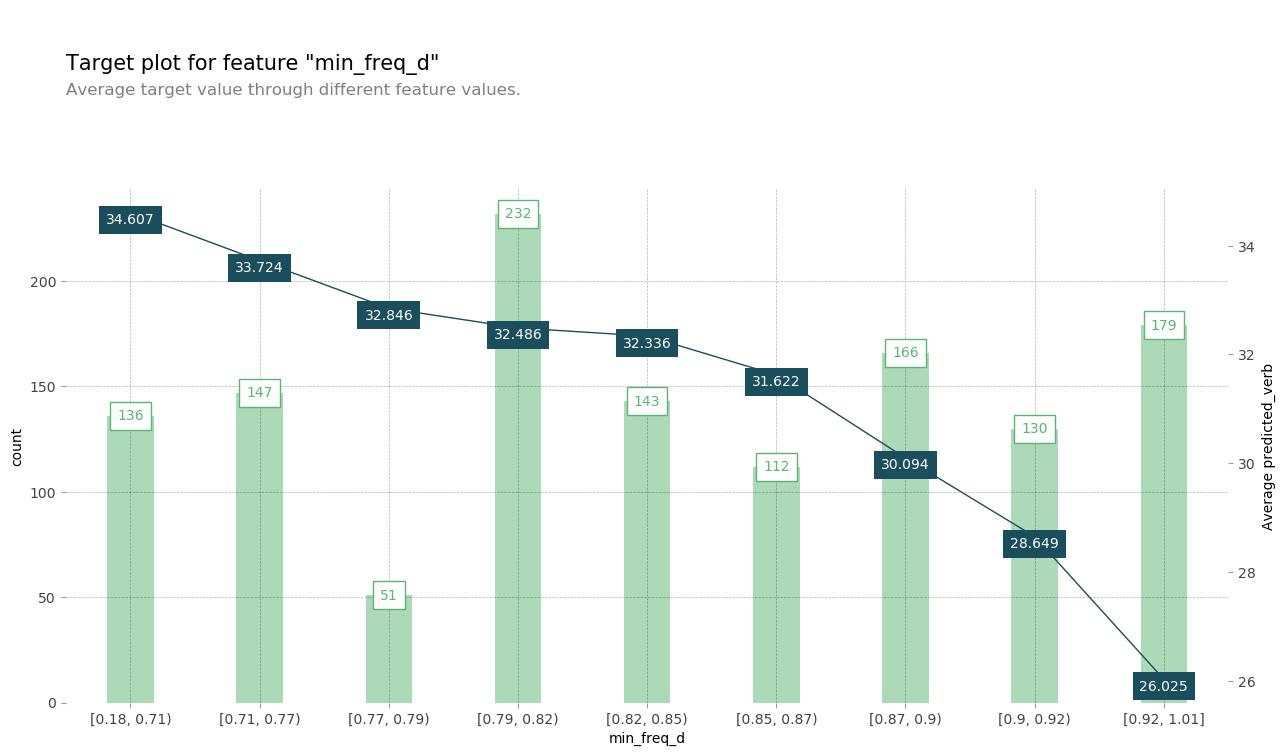

In [35]:
get_pdp_plot_figs('min_freq_d', 'verb')

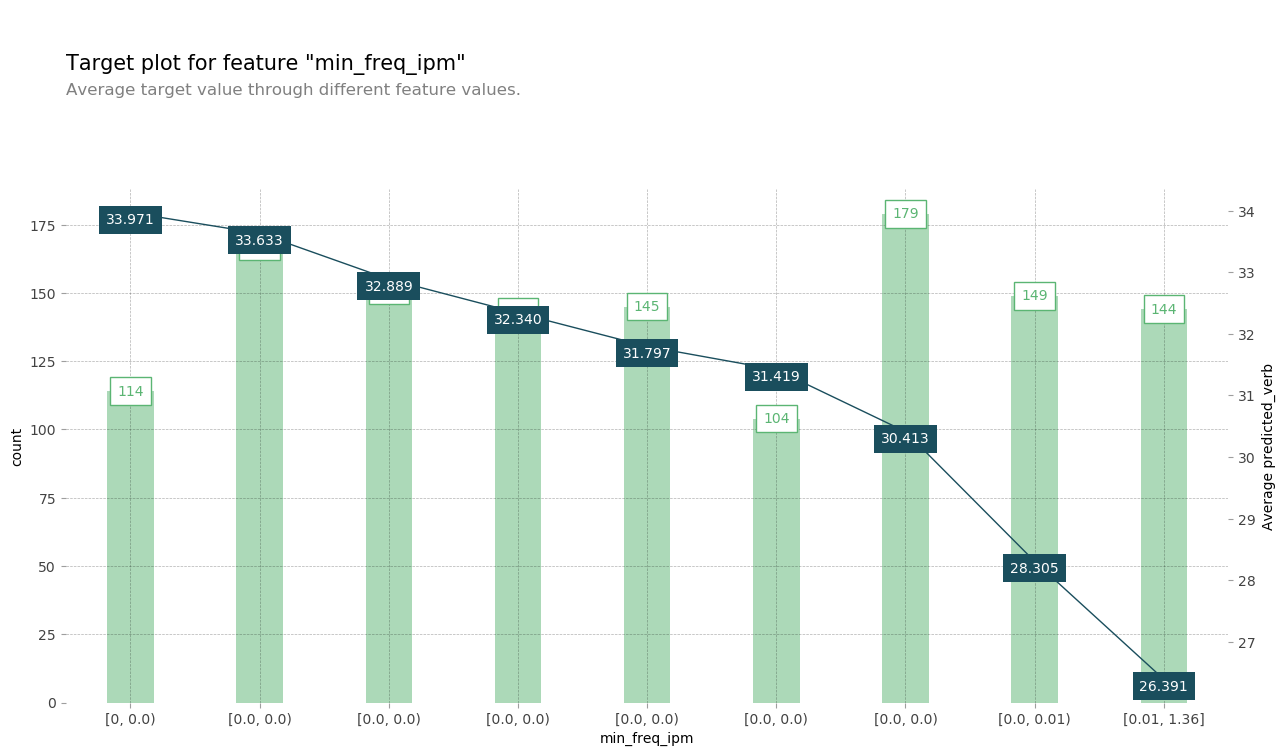

In [37]:
get_pdp_plot_figs('min_freq_ipm', 'verb')

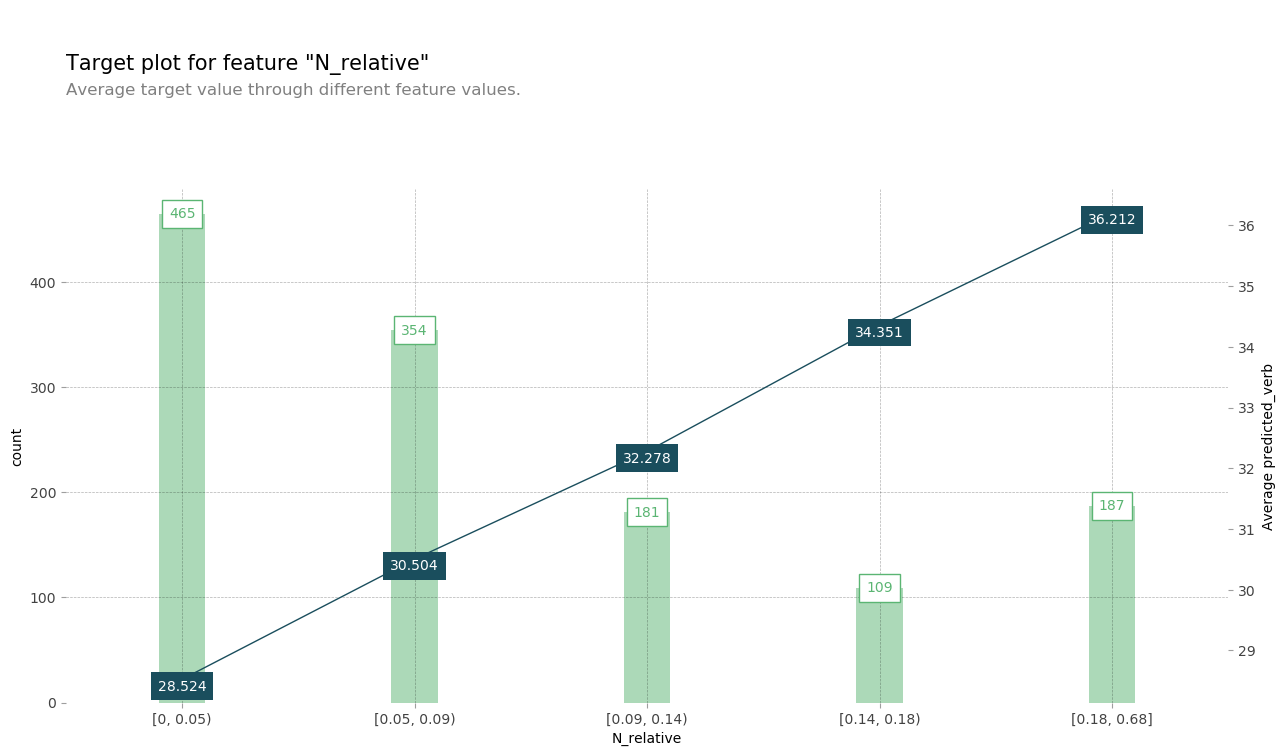

In [38]:
get_pdp_plot_figs('N_relative', 'verb')